#**Thông tin nhóm**
##Mã nhóm: 20CQ.PTDL.05
##Danh sách thành viên:
*   20120466 - Trần Thị Thu Hà
*   20120592 - Lê Minh Tiến
*   20120595 - Phạm Minh Tiến
*   20120624 - Mai Quyết Vang



#Thêm thư viện cần thiết

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

Load dữ liệu

In [55]:
link_p1 = "https://raw.githubusercontent.com/Vanniee007/ADA-Final-Project-20CQ.PTDL.05/main/data/Data_Train_p1.xlsx"
link_p2 = "https://raw.githubusercontent.com/Vanniee007/ADA-Final-Project-20CQ.PTDL.05/main/data/Data_Train_p2.xlsx"


In [56]:
# Đọc dữ liệu từ file Excel
Data_Train_p1 = pd.read_excel(link_p1)
Data_Train_p2 = pd.read_excel(link_p2)

# Ghép nối hai DataFrame
df = pd.concat([Data_Train_p1, Data_Train_p2], ignore_index=True)

df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


#Quan sát và phân tích tập dữ liệu (EDA)


##1. Cho biết kiểu dữ liệu của các thuộc tính


In [ ]:
# Hiển thị thông tin về DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10684 entries, 0 to 10683
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10684 non-null  object
 1   Date_of_Journey  10684 non-null  object
 2   Source           10684 non-null  object
 3   Destination      10684 non-null  object
 4   Route            10683 non-null  object
 5   Dep_Time         10684 non-null  object
 6   Arrival_Time     10684 non-null  object
 7   Duration         10684 non-null  object
 8   Total_Stops      10683 non-null  object
 9   Additional_Info  10684 non-null  object
 10  Price            10684 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.3+ KB


##2. Đối với cột Price, cho biết:


*   Giá cao nhất, thấp nhất, giá trung bình, mức giá xuất hiện nhiều
*   Độ lệch chuẩn của cột price?
*   Cho biết giá phân phối xung quanh trung tâm hay cách xa trung tâm?
Nhận xét về giá trị mean và median của tập dữ liệu.
*   Vẽ đồ thị histogram để nhận xét dữ liệu có bị lệch không?
List item





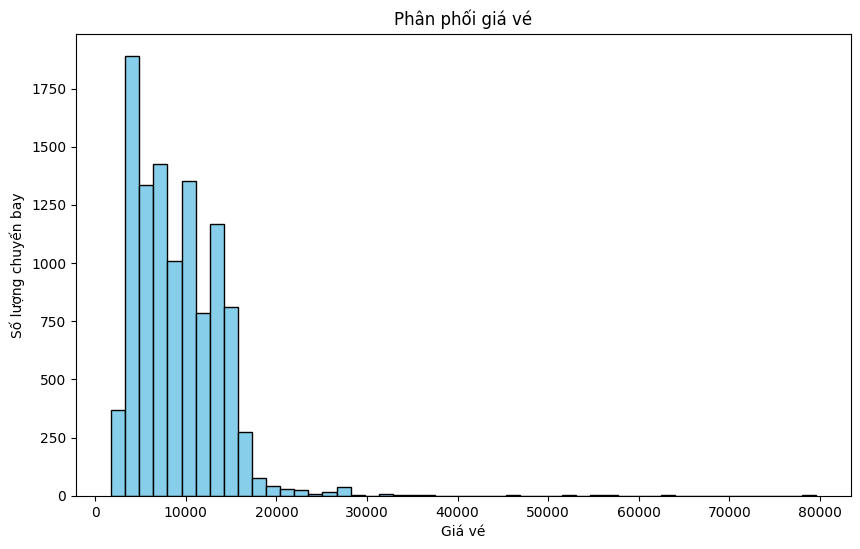

1. Giá cao nhất: 79512
   Giá thấp nhất: 1759
   Giá trung bình: 9087.696059159412
   Mức giá xuất hiện nhiều: 10262
2. Độ lệch chuẩn của cột Price: 4611.601485493901
3. Phân phối đối với giá vé có vẻ lệch phải so với trung bình.
4. Dựa trên biểu đồ histogram, ta thấy dữ liệu có dạng lệch phải. Biểu đồ có đỉnh lệch về phía phải, với nhiều giá trị dữ liệu cao hơn giá trị trung bình. Điều này có thể là do có một số chuyến bay có giá vé cao hơn đáng kể so với hầu hết các chuyến bay khác.


In [ ]:
# 1. Thống kê giá

max_price = df['Price'].max()
min_price = df['Price'].min()
mean_price = df['Price'].mean()
mode_price = df['Price'].mode().values[0]

# 2. Độ lệch chuẩn
std_dev_price = df['Price'].std()

# 3. So sánh mean và median
mean_median_comparison = "Phân phối đối với giá vé có vẻ {0} so với trung bình.".format(
    "lệch phải" if df['Price'].mean() > df['Price'].median() else "lệch trái"
)

# 4. Trực quan hóa dữ liệu bằng histogram
plt.figure(figsize=(10, 6))
plt.hist(df['Price'], bins=50, color='skyblue', edgecolor='black')
plt.title('Phân phối giá vé')
plt.xlabel('Giá vé')
plt.ylabel('Số lượng chuyến bay')
plt.show()


# Hiển thị kết quả
print(f"1. Giá cao nhất: {max_price}")
print(f"   Giá thấp nhất: {min_price}")
print(f"   Giá trung bình: {mean_price}")
print(f"   Mức giá xuất hiện nhiều: {mode_price}")
print(f"2. Độ lệch chuẩn của cột Price: {std_dev_price}")
print(f"3. {mean_median_comparison}")
print("4. Dựa trên biểu đồ histogram, ta thấy dữ liệu có dạng lệch phải. Biểu đồ có đỉnh lệch về phía phải, với nhiều giá trị dữ liệu cao hơn giá trị trung bình. Điều này có thể là do có một số chuyến bay có giá vé cao hơn đáng kể so với hầu hết các chuyến bay khác.")

##3. Mô tả số lượng missing value của mỗi thuộc tính


In [ ]:
# 3. Mô tả số lượng missing value của mỗi thuộc tính
missing_values = df.isnull().sum()
print("Số lượng missing value của mỗi thuộc tính:")
print(missing_values)

Số lượng missing value của mỗi thuộc tính:
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64


##4. Tính tỷ lệ % missing value của mỗi thuộc tính


In [ ]:
# 4. Tính tỷ lệ % missing value của mỗi thuộc tính
missing_percentage = (missing_values / len(df)) * 100
print("Tỷ lệ % missing value của mỗi thuộc tính:")
print(missing_percentage)

Tỷ lệ % missing value của mỗi thuộc tính:
Airline            0.00000
Date_of_Journey    0.00000
Source             0.00000
Destination        0.00000
Route              0.00936
Dep_Time           0.00000
Arrival_Time       0.00000
Duration           0.00000
Total_Stops        0.00936
Additional_Info    0.00000
Price              0.00000
dtype: float64


##5. Xử lý dữ liệu missing


In [ ]:
# 5. Xử lý dữ liệu missing ( xóa các dòng có missing value)
df.dropna(subset=['Total_Stops'], inplace=True)

##6. Outlier: sử dụng đồ thị boxplot để quan sát cột Price có tồn tại outlier không?

## Xử lí cột Duration: xử lí thành phút (int)


In [ ]:
import pandas as pd

# Tạo DataFrame mẫu
data = {'Duration': ['2h 50m', '19h', '30m']}
df = pd.DataFrame(data)

# Hàm xử lý để chuyển đổi chuỗi thời gian thành phút
def convert_duration_to_minutes(duration):
    if 'h' in duration and 'm' in duration:
        hours, minutes = map(int, duration.split('h'))
        return hours * 60 + minutes
    elif 'h' in duration:
        return int(duration.replace('h', '')) * 60
    elif 'm' in duration:
        return int(duration.replace('m', ''))
    else:
        return 0

# Áp dụng hàm xử lý cho cột "Duration"
df['Duration_minutes'] = df['Duration'].apply(convert_duration_to_minutes)

# Hiển thị kết quả
print(df[['Duration', 'Duration_minutes']])


## Xử lí Arival-Time thành Arival-Time (định dạng giờ)

In [ ]:
df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time']).dt.strftime('%I:%M')
df.head()

C:\Users\Vanniee\AppData\Local\Temp\ipykernel_1312\1920617473.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['Arrival_Time'] = pd.to_datetime(merged_data['Arrival_Time']).dt.strftime('%I:%M')


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10,170,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,01:15,445,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25,1140,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,11:30,325,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,09:35,285,1 stop,No info,13302


#Visualize dữ liệu dạng bảng hoặc đồ thị:

##1. Giá vé tăng khi nào?


##2. So sánh tỷ lệ các chuyến bay thẳng và trung chuyển (có dừng)


##3. Nước nào có lượng chuyến bay nhiều nhất?


##4. Hãng máy bay nào được khách đặt vé nhiều/thấp nhất?


##5. Tháng nào là tháng cao điểm


##6. Giá có thay đổi tùy theo hãng hàng không hay không?

In [ ]:
avg_price_by_airline = df.groupby('Airline')['Price'].mean().sort_values()
print(avg_price_by_airline)


Airline
Trujet                                4140.000000
SpiceJet                              4338.284841
Air Asia                              5590.260188
IndiGo                                5673.682903
GoAir                                 5861.056701
Vistara                               7796.348643
Vistara Premium economy               8962.333333
Air India                             9612.427756
Multiple carriers                    10902.678094
Multiple carriers Premium economy    11418.846154
Jet Airways                          11644.595325
Jet Airways Business                 58358.666667
Name: Price, dtype: float64


C:\Users\Vanniee\AppData\Local\Temp\ipykernel_1312\4142057488.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Airline', y='Price', data=df, ci=None)


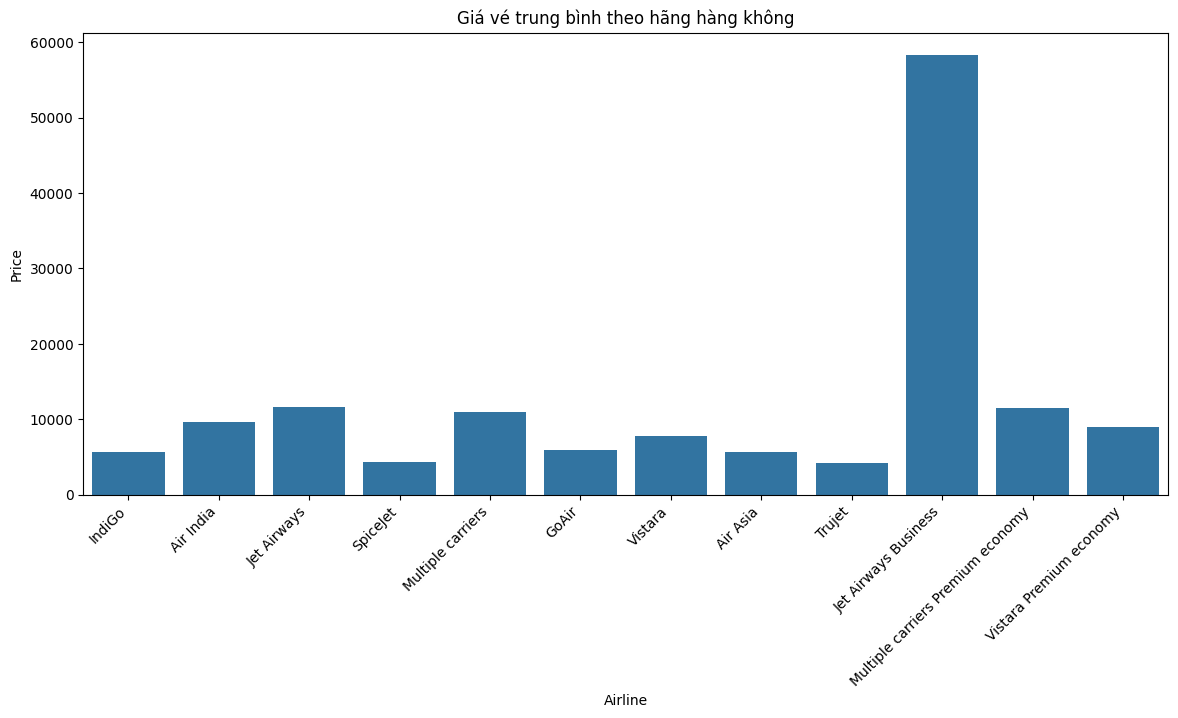

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(14, 6))
sns.barplot(x='Airline', y='Price', data=df, ci=None)
plt.xticks(rotation=45, ha='right')
plt.title('Giá vé trung bình theo hãng hàng không')
plt.show()


##7. Giá vé bị ảnh hưởng như thế nào khi mua vé chỉ 1 hoặc 2 ngày trước ngày khởi hành?


##8. Giá vé có thay đổi theo thời gian đi và đến không?


##9. Giá thay đổi như thế nào khi thay đổi Nguồn và Điểm đến?

#Kết luận các điểm chính quan sát được từ dữ liệu từ các gợi ý trên


#Ngoài các đặc trưng trong tập dữ liệu, các yếu tố nào có khả năng ảnh hưởng đến giá vé chuyến bay?



#Dự đoán giá vé